# Prediciting high school graduation rate of a cohort based on holistic data of the student population and school.

What do variables about:
- the broader structure of a school
- the experience of previous cohorts
- the freshmen, sophomore and junior year experience of rising seniors
tell us about the graduating % of rising seniors?

Data was gathered from https://www.isbe.net/pages/illinois-state-report-card-data.aspx
I have collected end of year data for the following academic years:
- 2018/19
- 2017/18
- 2016/17
- 2015/16
- 2014/15
- 2013/14
- 2012/13

I will look at the following cohorts for training the data:

- Class of 2017
- Class of 2016

and follow them thru their 4 years of high school (grades 9-12)

I will run validation on 
- Class of 2018

My test set with be 
- Class of 2019

The goal is to predict the 4-year high school graduation rate for this cohort.

# Sections
[Cleaning and exploring datasets](#Cleaning-and-exploring-datasets)
- [Class of 2019](#Class-of-2019)
- [Class of 2018](#Class-of-2018)
- [Class of 2017](#Class-of-2017)
- [Class of 2016](#Class-of-2016)
- [Class of 2015](#Class-of-2015)
- [Class of 2014](#Class-of-2014)
- [Class of 2013](#Class-of-2013)

[Concatenate dataframes](#Concatenate-dataframes)

[EDA on merged dataframe](#EDA-on-merged-dataframe)

[First Simple Model](#First-Simple-Model)




## Cleaning and exploring datasets

Gathering the data for each of the academic years 2013 - 2017 involved downloading semi-colon separated .txt files, importing them into a spreadsheet, then matching the columns to headers that were recorded in a separate .xls file. While performing this task, I also selected feature set to use for this project.

I also added a column to every academic year to identify the cohort by their graduation year (e.g. 2018). 

I will create a matrix of the information for each cohort.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# import additional libraries
import pandasql as ps
from pandasql import sqldf

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# functions from .py file
import src.eda_functions as fun

# pysqldf lambda function
pysqldf = lambda q: sqldf(q, globals())

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

### Step 1
create a dataframe for each academic year for schools that serve grades 9 - 12.
This will include traditional high schools and some charter schools that serve grades in addition to 9 - 12. This may have an impact on features such as the total number of students in a school, attendance rate and I will have to be aware and make corrections if needed.

### Class of 2019

In [4]:
df_19 = pd.read_excel('../../data/2019-Report-Card-Public-Data-Set_clean.xlsx', sheet_name="General")
df_19.shape

(4738, 35)

In [5]:
fun.clean_col(df_19)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [6]:
# create query to return schools with grades 9-12

q1 = """SELECT * 
       FROM df_19
       WHERE grades_served LIKE "%12%";"""

hs_19 = pysqldf(q1)

In [7]:
hs_19.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2019,010010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,86.8,2.0,68.8,68.8,95.6,NaN,NaN,NaN
1,2019,010010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,83.9,2.0,58.1,58.1,94.0,NaN,NaN,NaN
2,2019,010010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.3,2.0,75.0,73.3,94.9,NaN,NaN,NaN
3,2019,010010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,86.4,1.0,60.7,60.7,92.9,NaN,NaN,27.0
4,2019,010011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,None,None,86.4,2.0,67.7,65.7,74.9,68.0,127.0,126.0


In [8]:
hs_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      720 non-null    int64  
 1   rcdts                                                                       720 non-null    object 
 2   school_name                                                                 720 non-null    object 
 3   district                                                                    720 non-null    object 
 4   city                                                                        720 non-null    object 
 5   county                                                                      720 non-null    object 
 6   district_type                                     

There are some columns that are have nulls. I am going to have to fix those.

the `percentage_student_enrollment`... nulls can be changed to zero.
I am assuming the same can be applied to columns 31-34. 

Will need to investigate further to see why there are missing values in 18-30.

In [9]:
hs_19.percent_student_enrollment_white.isna().sum()

38

In [10]:
hs_19.percent_student_enrollment_white.sort_values(na_position='first')

191      NaN
196      NaN
197      NaN
199      NaN
206      NaN
       ...  
159    100.0
179    100.0
454    100.0
166    100.0
422    100.0
Name: percent_student_enrollment_white, Length: 720, dtype: float64

In [11]:
hs_19.percent_student_enrollment_white.replace(np.nan, 0, inplace=True)

In [12]:
hs_19.percent_student_enrollment_white.isna().sum()

0

OK. that did the trick. Time to do the same for the other enrollment columns

In [13]:
hs_19.percent_student_enrollment_black_or_african_american.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_hispanic_or_latino.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_asian.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_native_hawaiian_or_other_pacific_islander.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_american_indian_or_alaska_native.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_two_or_more_races.replace(np.nan, 0, inplace=True)

...and the AP classes columns

In [14]:
hs_19.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_19.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_19.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [15]:
hs_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      720 non-null    int64  
 1   rcdts                                                                       720 non-null    object 
 2   school_name                                                                 720 non-null    object 
 3   district                                                                    720 non-null    object 
 4   city                                                                        720 non-null    object 
 5   county                                                                      720 non-null    object 
 6   district_type                                     

In [16]:
hs_19.to_csv('../../data/test_set.csv', index=False)

### Class of 2018

In [17]:
df_18 = pd.read_excel('../../data/2018-Report-Card-Public-Data-Set_clean.xlsx', sheet_name="General")
df_18.shape

(4754, 35)

In [18]:
fun.clean_col(df_18)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [19]:
q2 = """SELECT * 
       FROM df_18
       WHERE grades_served LIKE "%12%";"""

hs_18 = pysqldf(q2)

In [20]:
hs_18.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2018,010010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,90.6,2.0,81.5,81.5,100.0,NaN,NaN,NaN
1,2018,010010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,84.8,2.0,80.4,80.4,93.0,NaN,NaN,NaN
2,2018,010010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.7,1.0,75.0,75.0,94.0,NaN,NaN,NaN
3,2018,010010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.7,1.0,74.0,72.0,80.0,NaN,NaN,20.0
4,2018,010011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,None,None,81.9,3.0,68.9,68.2,51.0,109.0,110.0,148.0


In [21]:
hs_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      721 non-null    int64  
 1   rcdts                                                                       721 non-null    object 
 2   school_name                                                                 721 non-null    object 
 3   district                                                                    721 non-null    object 
 4   city                                                                        721 non-null    object 
 5   county                                                                      721 non-null    object 
 6   district_type                                     

Going to do the same clean up on hs_18

In [22]:
hs_18.percent_student_enrollment_white.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_black_or_african_american.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_hispanic_or_latino.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_asian.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_native_hawaiian_or_other_pacific_islander.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_american_indian_or_alaska_native.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_two_or_more_races.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [23]:
hs_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      721 non-null    int64  
 1   rcdts                                                                       721 non-null    object 
 2   school_name                                                                 721 non-null    object 
 3   district                                                                    721 non-null    object 
 4   city                                                                        721 non-null    object 
 5   county                                                                      721 non-null    object 
 6   district_type                                     

In [24]:
hs_18.to_csv('../../data/val_set.csv', index=False)

### Class of 2017

In [25]:
df_17 = pd.read_excel('../../data/2017-Report-Card-Public-Data-Set_clean.xlsx')
df_17.shape

(3796, 35)

In [26]:
fun.clean_col(df_17)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [27]:
q3 = """SELECT * 
       FROM df_17
       WHERE grades_served LIKE "%12%";"""

hs_17 = pysqldf(q3)

In [28]:
hs_17.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2017,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,10.1,"$36,294",87.5,2,66.7,66.7,84.6,0,0,0
1,2017,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,23.5,"$41,061",71.1,2,70.8,66.7,89.1,0,0,0
2,2017,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.8,"$45,975",71.4,2,73.2,64.3,89.1,0,0,0
3,2017,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,17.5,"$40,873",82.1,1,64.1,59,84.3,0,0,18
4,2017,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,28.5,"$41,946",77.4,2,69.8,65.1,63.1,93,122,125


In [29]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

Columns 21-34 should be floats, not objects

In [30]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_17[cols] = hs_17[cols].apply(pd.to_numeric, errors='coerce', axis=1)
        

In [31]:
hs_17.high_school_dropout_rate_total.unique()

array([ 0.7,  0. ,  0.8,  0.4,  1.9,  1.6,  0.5,  1.4,  2.9,  3.5,  3.8,
        2.2,  1.5,  2.6,  1.1,  2.7,  3.3,  0.9,  2.3,  1. ,  0.6,  1.2,
        5.2,  7.5,  3. ,  4.7,  3.2,  1.3,  0.1,  0.3,  0.2,  8. ,  1.8,
        3.1,  2.5,  1.7,  5.5,  2.4,  3.6, 18.4,  2. ,  5. ,  2.1,  8.5,
        4.1,  3.9, 48.1, 45.4, 33.6, 66.2, 49.4, 62.2, 44.2, 40.2, 65. ,
       39.6, 57.7, 45.2, 38.1,  4.3, 55.6, 53.6, 56.6, 28.4,  9.9,  7.8,
        3.4, 40.8,  nan, 17. ,  2.8,  7.1, 10.9,  4. ,  4.4,  4.6, 10.3,
       15.3,  4.5,  3.7, 13.2,  6.9,  5.3,  5.6, 21.2,  6.6])

It looks like there are some hidden empty strings in here. Need to convert those to nans, then figure out how to handle those...

In [32]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

In [33]:
# replacing nans with zeros
hs_17.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_17.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_17.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [34]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

### Class of 2016

In [35]:
df_16 = pd.read_excel('../../data/2016-Report-Card-Public-Data-Set_clean.xlsx')
df_16.shape

(3735, 35)

In [36]:
fun.clean_col(df_16)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [37]:
q4 = """SELECT * 
       FROM df_16
       WHERE grades_served LIKE "%12%";"""

hs_16 = pysqldf(q4)

In [38]:
hs_16.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2016,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,8.4,"$34,801",82.1,3,65,65,77.8,0,0,0
1,2016,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,16.7,"$40,883",76.8,1,77.3,70.5,97.9,,,
2,2016,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.7,"$46,882",77.4,2,76.7,70,94.3,0,0,0
3,2016,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.6,"$40,823",80.3,1,63.6,60,84.4,0,0,21
4,2016,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,26.4,"$44,780",79.6,2,62.2,57.1,,144,161,157


In [39]:
hs_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      670 non-null    int64  
 1   rcdts                                                                       670 non-null    object 
 2   school_name                                                                 670 non-null    object 
 3   district                                                                    670 non-null    object 
 4   city                                                                        670 non-null    object 
 5   county                                                                      670 non-null    object 
 6   district_type                                     

In [40]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_16[cols] = hs_16[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [41]:
hs_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      670 non-null    int64  
 1   rcdts                                                                       670 non-null    object 
 2   school_name                                                                 670 non-null    object 
 3   district                                                                    670 non-null    object 
 4   city                                                                        670 non-null    object 
 5   county                                                                      670 non-null    object 
 6   district_type                                     

In [42]:
# replacing nans with zeros
hs_16.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_16.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_16.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

### Class of 2015


In [43]:
df_15 = pd.read_excel('../../data/2015-Report-Card-Public-Data-Set_clean.xlsx')
df_15.shape

(3764, 35)

In [44]:
fun.clean_col(df_15)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [45]:
q5 = """SELECT * 
       FROM df_15
       WHERE grades_served LIKE "%12%";"""

hs_15 = pysqldf(q5)

In [46]:
hs_15.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2015,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,7.6,"$33,771",73.7,3,72.7,69.7,93,None,None,None
1,2015,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,17.2,"$41,447",74.1,1,81.6,77.6,97.4,None,None,None
2,2015,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.1,"$46,534",74.6,2,64.1,60.9,95.8,None,None,None
3,2015,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,14.4,"$40,549",82,1,69.8,69.8,71.7,None,None,None
4,2015,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,22.6,"$44,849",81.7,2,66.2,62.7,,None,None,None


In [47]:
hs_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      671 non-null    int64  
 1   rcdts                                                                       671 non-null    object 
 2   school_name                                                                 671 non-null    object 
 3   district                                                                    671 non-null    object 
 4   city                                                                        671 non-null    object 
 5   county                                                                      671 non-null    object 
 6   district_type                                     

In [48]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_15[cols] = hs_15[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [49]:
hs_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      671 non-null    int64  
 1   rcdts                                                                       671 non-null    object 
 2   school_name                                                                 671 non-null    object 
 3   district                                                                    671 non-null    object 
 4   city                                                                        671 non-null    object 
 5   county                                                                      671 non-null    object 
 6   district_type                                     

### Class of 2014

In [50]:
df_14 = pd.read_excel('../../data/2014-Report-Card-Public-Data-Set_clean.xlsx')
df_14.shape

(3794, 35)

In [51]:
fun.clean_col(df_14)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [52]:
q6 = """SELECT * 
       FROM df_14
       WHERE grades_served LIKE "%12%";"""

hs_14 = pysqldf(q6)

In [53]:
hs_14.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2014,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,9.7,"$40,711",69.5,2,None,None,None,None,None,None
1,2014,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,14.8,"$40,764",86,1,None,None,None,None,None,None
2,2014,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.4,"$46,756",80,2,None,None,None,None,None,None
3,2014,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.4,"$40,744",81.7,1,None,None,None,None,None,None
4,2014,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,19.1,"$44,812",87.6,3,None,None,None,None,None,None


In [54]:
hs_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

In [55]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_14[cols] = hs_14[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [56]:
hs_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

### Class of 2013

In [57]:
df_13 = pd.read_excel('../../data/2013-Report-Card-Public-Data-Set_clean.xlsx')
df_13.shape

(3862, 35)

In [58]:
fun.clean_col(df_13)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [59]:
q7 = """SELECT * 
       FROM df_13
       WHERE grades_served LIKE "%12%";"""

hs_13 = pysqldf(q7)

In [60]:
hs_13.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2013,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,SMALL,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,2013,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
2,2013,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,2013,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,2013,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,None,None,None,None,None,None,None,None,None,None


In [61]:
hs_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

In [62]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_13[cols] = hs_13[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [63]:
hs_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

# look for missing targets

In [64]:
hs_19.high_school_4_year_graduation_rate_total.isna().sum()

5

In [65]:
hs_18.high_school_4_year_graduation_rate_total.isna().sum()

5

In [66]:
hs_17.high_school_4_year_graduation_rate_total.isna().sum()

6

In [67]:
hs_16.high_school_4_year_graduation_rate_total.isna().sum()

4

In [68]:
hs_15.high_school_4_year_graduation_rate_total.isna().sum()

5

In [69]:
hs_14.high_school_4_year_graduation_rate_total.isna().sum()

2

In [70]:
hs_13.high_school_4_year_graduation_rate_total.isna().sum()

2

## Concatenate dataframes 
create a matrix where one row is the cohort of a school (e.g. cohort 2018 for school xxx1, cohort 2017 for xxx1, cohort 2018 for school yyy2, cohort 2017 for school yyy2).

In [71]:
columns_check= list(hs_19.columns)

dataframes_check = [hs_13,hs_14, hs_15, hs_16, hs_17, hs_18]
missing = {}
for idx, dataframe in enumerate(dataframes_check):
    missing_columns = [x for x in columns_check if x not in dataframes_check[idx].columns]
    if missing_columns:
        missing[idx]=missing_columns

In [72]:
missing

{}

In [73]:
final_features=['cohort','rcdts','school_name','district','city','county','district_type', 'district_size',
                'school_type','grades_served','percent_student_enrollment_white',
                'percent_student_enrollment_black_or_african_american',
                'percent_student_enrollment_hispanic_or_latino','percent_student_enrollment_asian',
                'percent_student_enrollment_native_hawaiian_or_other_pacific_islander','percent_student_enrollment_american_indian_or_alaska_native','percent_student_enrollment_two_or_more_races',
                'number_student_enrollment','total_number_of_school_days','student_attendance_rate','student_chronic_truancy_rate',
                'high_school_dropout_rate_total','high_school_4_year_graduation_rate_total','high_school_5_year_graduation_rate_total',
                'avg_class_size_high_school','pupil_teacher_ratio_high_school','teacher_retention_rate',
                'principal_turnover_within_6_years','percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months','percent_9th_grade_on_track',
                'number_students_who_took_ap_classes_grade_10_total','number_students_who_took_ap_classes_grade_11_total',
                'number_students_who_took_ap_classes_grade_12_total']
final_features
all_dfs=[hs_13, hs_14, hs_15, hs_16, hs_17]
filtered_dfs=[]

for dataframe in all_dfs:
    filtered_dfs.append(dataframe[final_features])
    
merged_df = pd.concat(all_dfs) 

## EDA on merged dataframe
additional cleaning and sorting 

In [74]:
fun.proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,34,0.009991,float64,3369,17.466043,17.7,0.3,81
city,0,0.000000,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.000000,int64,3403,2015.020276,2015.0,2013,2017
county,0,0.000000,object,3403,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.000000,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.000000,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.000000,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,19,0.005583,float64,3384,85.283008,88.5,0,100
high_school_5_year_graduation_rate_total,60,0.017632,float64,3343,87.718516,90.3,2.6,100


I may almost be done cleaning, right?

In [75]:
# cohort should be a category
merged_df['cohort'] = merged_df['cohort'].astype('object')
# check that again
list(merged_df.select_dtypes(['object', 'bool']))

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'student_chronic_truancy_rate']

Now to make some decisions about features to keep and dealing with nans

In [76]:
merged_df.isnull().sum().sort_values(ascending=False)

teacher_avg_salary                                                            3403
number_students_who_took_ap_classes_grade_12_total                            2021
number_students_who_took_ap_classes_grade_11_total                            2021
number_students_who_took_ap_classes_grade_10_total                            2021
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months    1440
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    1440
percent_9th_grade_on_track                                                    1411
principal_turnover_within_6_years                                              753
teacher_retention_rate                                                         732
pupil_teacher_ratio_high_school                                                682
high_school_5_year_graduation_rate_total                                        60
avg_class_size_high_school                                                      34
high

Starting from the top down:
- Avg teacher salary will be dropped. The data is recorded at the disctrict level, but not by school. Also I've reconsidered the usefulness of that item
- AP classes. I feel like this is important. It wasn't entered for 2013 or 2014, which is a lot of missing values. Since they are more than 50% nans, I will most likel drop them. I do wnt to run a model with them first, tho.
- Percent of Graduates columns. Replace with mean.
- Percent of 9th graders. Replace with mean.
- Principal turnover. I'm going to drop. Like teacher salary, I'm not sure how important it really is.
- Teacher retention rate. Replace with mean. I feel like this is more important than principal turnover.
- Pupil:Teacher ratio. Replace with mean.
- 5 year graduation rate. Replace with mean.
- Avg class size. Replace with mean.
- Dropout rate. Replace with mean.

- 4 year grad rate. Since this is the target, I need to do some more digging and try to find a real explanation for these nans.

In [77]:
print(f'Number of nans in 2019 target: {hs_19.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2018 target: {hs_18.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2017 target: {hs_17.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2016 target: {hs_16.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2015 target: {hs_15.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2014 target: {hs_14.high_school_4_year_graduation_rate_total.isna().sum()}')
print(f'Number of nans in 2013 target: {hs_13.high_school_4_year_graduation_rate_total.isna().sum()}')

Number of nans in 2019 target: 5
Number of nans in 2018 target: 5
Number of nans in 2017 target: 6
Number of nans in 2016 target: 4
Number of nans in 2015 target: 5
Number of nans in 2014 target: 2
Number of nans in 2013 target: 2


__Edit__: Since it was a small number missing in each year, I returned to the datasets, and ISBE website to research and can confirm that these nans should be zeros. These are primarily small class sizes and/or schools with struggling graduation rates.

__Additional Note__: The nans for Graduate and % 9th grade on track can also be changed to zeros.

In [78]:
merged_df_copy = merged_df.drop(['teacher_avg_salary',
                                 'principal_turnover_within_6_years'], axis=1).copy()

In [79]:
merged_df_copy.isnull().sum().sort_values(ascending=False)

number_students_who_took_ap_classes_grade_12_total                            2021
number_students_who_took_ap_classes_grade_11_total                            2021
number_students_who_took_ap_classes_grade_10_total                            2021
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months    1440
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    1440
percent_9th_grade_on_track                                                    1411
teacher_retention_rate                                                         732
pupil_teacher_ratio_high_school                                                682
high_school_5_year_graduation_rate_total                                        60
avg_class_size_high_school                                                      34
high_school_4_year_graduation_rate_total                                        19
high_school_dropout_rate_total                                                   2
rcdt

In [80]:
merged_df_copy.to_csv('../../data/train_set.csv', index=False)

### Step 4 check correlations


In [81]:
num_features = merged_df_copy.select_dtypes(['float64', 'int64'])

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


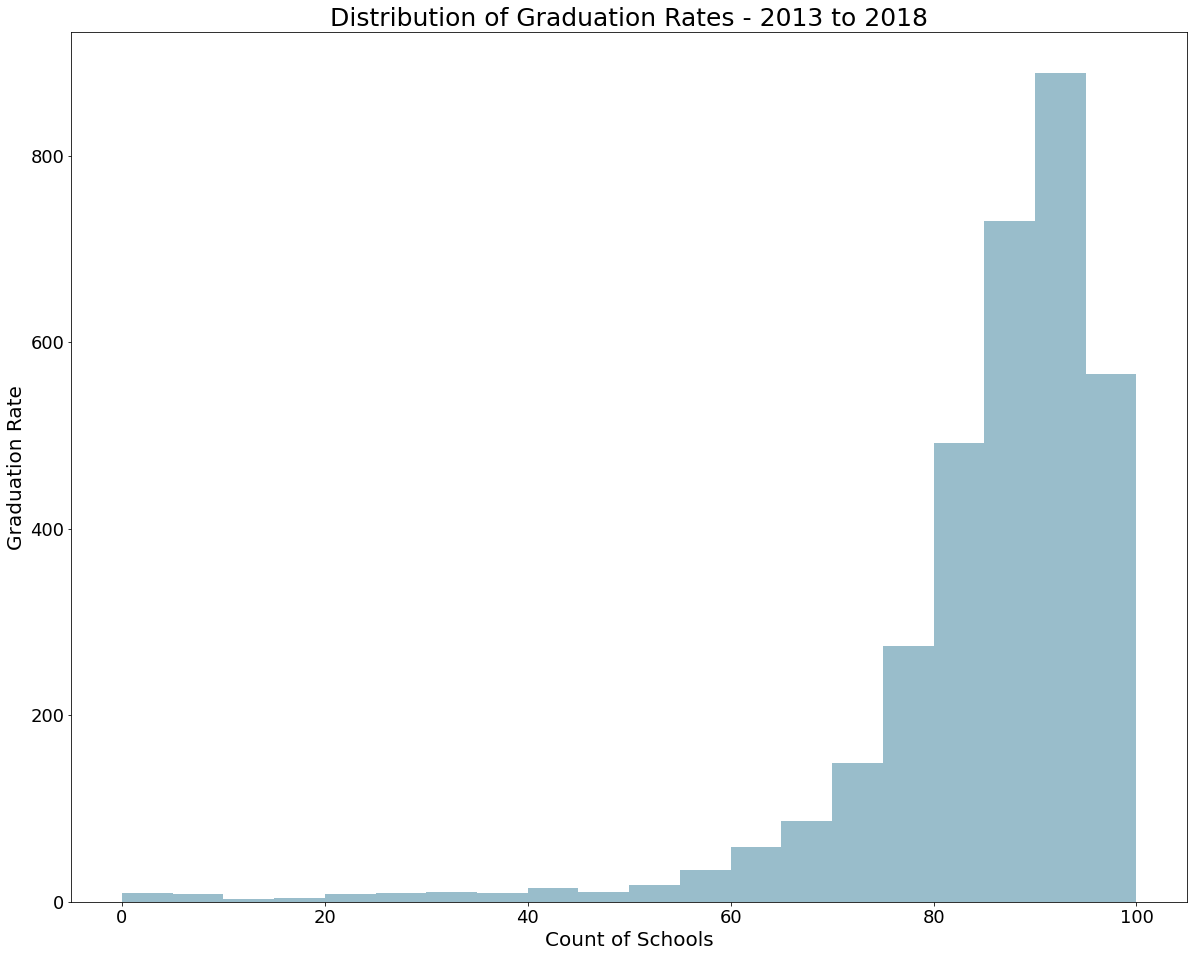

In [82]:
fig = plt.subplots(figsize=(20,16))
plt.hist(merged_df.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('Distribution of Graduation Rates - 2013 to 2018')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
#plt.tight_layout()
plt.savefig('figures/2019_hist.png')
plt.show();

In [83]:
merged_df.high_school_4_year_graduation_rate_total.describe()

count    3384.000000
mean       85.283008
std        13.163674
min         0.000000
25%        81.600000
50%        88.500000
75%        93.300000
max       100.000000
Name: high_school_4_year_graduation_rate_total, dtype: float64

That is a very left skewed distribution. I should try log transforming the target to see if that makes a difference.

First, I want to check the correlations and run a FSM

In [84]:
num_features.corr()['high_school_4_year_graduation_rate_total'].sort_values(ascending=False)

high_school_4_year_graduation_rate_total                                      1.000000
high_school_5_year_graduation_rate_total                                      0.722927
student_attendance_rate                                                       0.569103
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months    0.457588
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    0.454771
percent_9th_grade_on_track                                                    0.406497
percent_student_enrollment_white                                              0.329463
teacher_retention_rate                                                        0.328447
number_students_who_took_ap_classes_grade_12_total                            0.211697
number_students_who_took_ap_classes_grade_11_total                            0.206262
number_students_who_took_ap_classes_grade_10_total                            0.198108
percent_student_enrollment_asian           

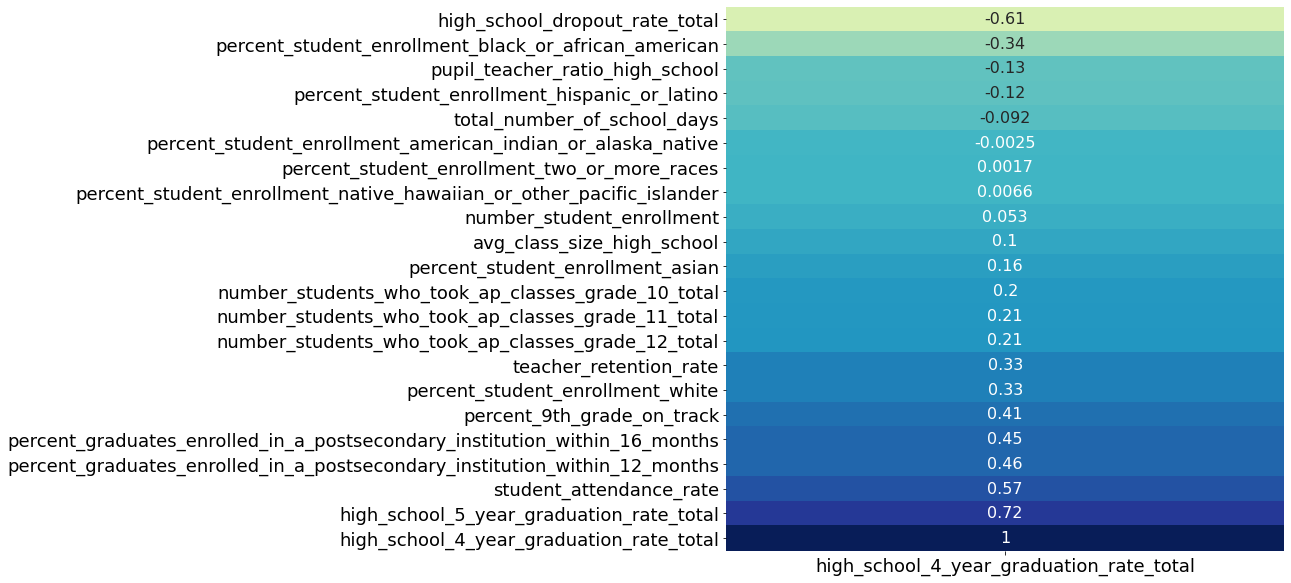

In [85]:
fun.heatmap(num_features, 'high_school_4_year_graduation_rate_total');

In [86]:
fsm = fun.forward_selected(num_features, 'high_school_4_year_graduation_rate_total')

fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.631
Model:                                                  OLS   Adj. R-squared:                  0.627
Method:                                       Least Squares   F-statistic:                     141.4
Date:                                      Mon, 10 Aug 2020   Prob (F-statistic):          2.22e-272
Time:                                              14:33:11   Log-Likelihood:                -4693.4
No. Observations:                                      1338   AIC:                             9421.
Df Residuals:                                          1321   BIC:                             9509.
Df Model:                                                16                                         
Covariance Type:                                  nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -388.7573    313.963     -1.238      0.216   -1004.677     227.162
high_school_5_year_graduation_rate_total                                 0.5572      0.027     20.265      0.000       0.503       0.611
student_attendance_rate                                                  0.1751      0.073      2.390      0.017       0.031       0.319
number_students_who_took_ap_classes_grade_12_total                       0.0213      0.007      3.135      0.002       0.008       0.035
high_school_dropout_rate_total                                          -0.4268      0.057     -7.440      0.000      -0.539      -0.314
number_student_enrollment                                               -0.0026      0.000     -6.525      0.000      -0.003      -0.002
percent_student_enrollment_white                                         3.7909      3.129      1.211      0.226      -2.348       9.930
pupil_teacher_ratio_high_school                                          0.1506      0.066      2.279      0.023       0.021       0.280
percent_student_enrollment_american_indian_or_alaska_native              4.8602      3.189      1.524      0.128      -1.396      11.116
total_number_of_school_days                                              0.1773      0.122      1.448      0.148      -0.063       0.417
percent_student_enrollment_asian                                         3.7171      3.130      1.188      0.235      -2.422       9.857
number_students_who_took_ap_classes_grade_11_total                       0.0070      0.009      0.826      0.409      -0.010       0.024
number_students_who_took_ap_classes_grade_10_total                      -0.0040      0.007     -0.550      0.582      -0.018       0.010
percent_student_enrollment_two_or_more_races                             3.6984      3.132      1.181      0.238      -2.446       9.843
percent_student_enrollment_black_or_african_american                     3.7559      3.129      1.200      0.230      -2.382       9.894
percent_student_enrollment_hispanic_or_latino                            3.7529      3.130      1.199      0.231      -2.387       9.893
percent_student_enrollment_native_hawaiian_or_other_pacific_islander     3.8846      3.268      1.189      0.235      -2.526      10.295
==============================================================================
Omnibus:              

The first model returned an Adjusted R2 of 0.627. Not terrible. Hopefully some room for improvement.

Also want to make note of the features that were selected by this model:
- high_school_5_year_graduation_rate_total
- student_attendance_rate
- number_students_who_took_ap_classes_grade_12_total
- high_school_dropout_rate_total
- number_student_enrollment
- percent_student_enrollment_white
- pupil_teacher_ratio_high_school
- percent_student_enrollment_american_indian_or_alaska_native
- total_number_of_school_days
- percent_student_enrollment_asian
- number_students_who_took_ap_classes_grade_11_total
- number_students_who_took_ap_classes_grade_10_total
- percent_student_enrollment_two_or_more_races
- percent_student_enrollment_black_or_african_american
- percent_student_enrollment_hispanic_or_latino
- percent_student_enrollment_native_hawaiian_or_other_pacific_islander

##### Dropping the AP classes and running the model again.

In [87]:
num_features_copy = num_features.drop(['number_students_who_took_ap_classes_grade_10_total', 
                                'number_students_who_took_ap_classes_grade_11_total', 
                                'number_students_who_took_ap_classes_grade_12_total'], axis =1).copy()

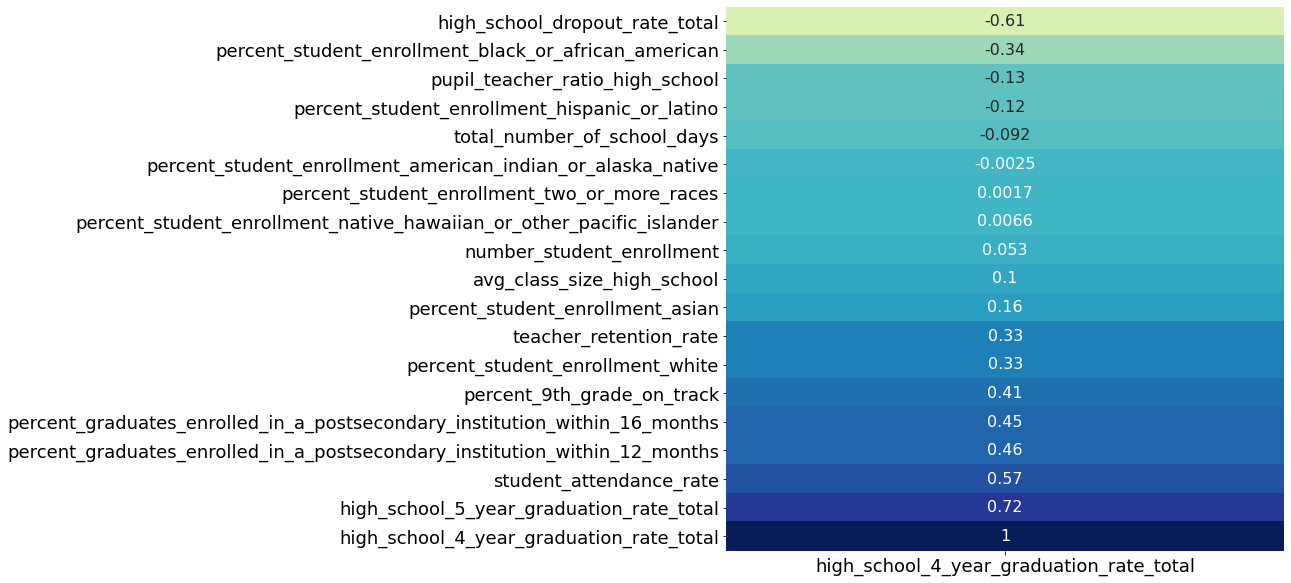

In [88]:
fun.heatmap(num_features_copy, 'high_school_4_year_graduation_rate_total');

In [89]:
ssm = fun.forward_selected(num_features_copy, 'high_school_4_year_graduation_rate_total')

ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.600
Model:                                                  OLS   Adj. R-squared:                  0.596
Method:                                       Least Squares   F-statistic:                     180.7
Date:                                      Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                                              14:33:15   Log-Likelihood:                -6786.3
No. Observations:                                      1947   AIC:                         1.361e+04
Df Residuals:                                          1930   BIC:                         1.370e+04
Df Model:                                                16                                         
Covariance Type:                                  nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -200.9196    254.823     -0.788      0.431    -700.677     298.837
high_school_5_year_graduation_rate_total                                       0.5827      0.025     23.634      0.000       0.534       0.631
student_attendance_rate                                                        0.1838      0.068      2.708      0.007       0.051       0.317
high_school_dropout_rate_total                                                -0.7080      0.061    -11.516      0.000      -0.829      -0.587
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months     0.0498      0.063      0.793      0.428      -0.073       0.173
teacher_retention_rate                                                         0.0518      0.019      2.765      0.006       0.015       0.089
number_student_enrollment                                                     -0.0008      0.000     -3.514      0.000      -0.001      -0.000
percent_student_enrollment_black_or_african_american                           1.8702      2.540      0.736      0.462      -3.110       6.851
pupil_teacher_ratio_high_school                                                0.0962      0.055      1.746      0.081      -0.012       0.204
percent_student_enrollment_native_hawaiian_or_other_pacific_islander           0.2556      2.682      0.095      0.924      -5.005       5.516
percent_student_enrollment_asian                                               1.9482      2.539      0.767      0.443      -3.032       6.929
percent_student_enrollment_hispanic_or_latino                                  1.8831      2.540      0.741      0.459      -3.098       6.864
total_number_of_school_days                                                    0.1214      0.105      1.151      0.250      -0.085       0.328
percent_student_enrollment_white                                               1.8959      2.540      0.746      0.455      -3.085       6.877
percent_student_enrollment_american_indian_or_alaska_native                    2.1631      2.595      0.834      0.405      -2.925       7.251
percent_student_enrollment_two_or_more_races                                   1.9794      2.541      0.779      0.436      -3.003       6.962
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months     0.0166      0.065      0.255      0.798      

This model returned an Adj R2 of 0.596. N0t an insignificant amount. Maybe I should keep the AP classes after all?

In [90]:
merged_df_copy['high_school_4_year_graduation_rate_total'] = np.log(merged_df_copy['high_school_4_year_graduation_rate_total'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 4.605170185988092] is not finite

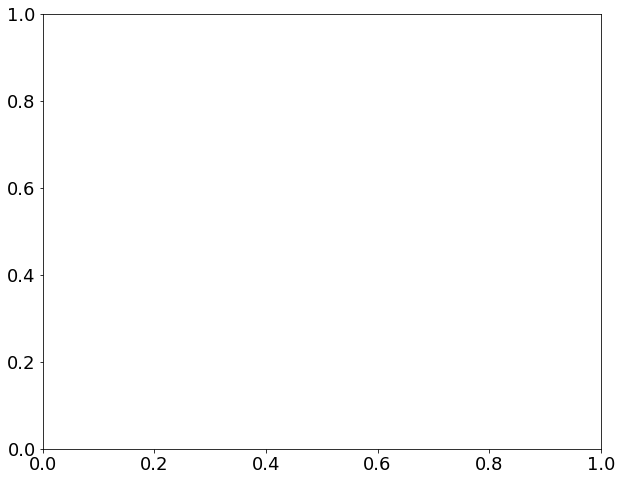

In [91]:
fig = plt.subplots(figsize=(10,8))
plt.hist(merged_df_copy.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('Distribution of Graduation Rates - 2013 to 2018')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
#plt.tight_layout()
#plt.savefig('figures/2019_hist.png')
#plt.show()
;

In [ ]:
fun.heatmap(merged_df_copy, 'high_school_4_year_graduation_rate_total');

In [ ]:
tsm = fun.forward_selected(merged_df_copy, 'high_school_4_year_graduation_rate_total')

tsm.summary()